In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import missingno as msno

In [2]:
df=pd.read_csv('Base_Problem_DataSet.csv',low_memory=False)
num_feat=[x for x in df.columns if df[x].dtype!='O']
cat_feat=[x for x in df.columns if df[x].dtype=='O']

#categorical values  that are wrongly flaagged as numericals


# Preprocessing


### Changing Improper Categories and Numerics

In [3]:
imporoper_categories={ x:len(df[x].value_counts()) for x in cat_feat if len(df[x].value_counts())> 30 and  len(df[x].value_counts())!=58 }
#numerical values  that are wrongly flaagged as categories
improper_numeric={x:len(df[x].value_counts()) for x in num_feat if len(df[x].value_counts())< 30}
num_feat.extend(imporoper_categories.keys())
num_feat=[ x for x in num_feat if x not in improper_numeric]
cat_feat.extend(improper_numeric.keys())
cat_feat=[ x for x in cat_feat if x not in imporoper_categories]
for i in imporoper_categories.keys() :
    df[i].replace(['#VALUE!','@','#','x','$','&'],0,inplace=True)
    df[i]=df[i].astype('float')
for i in improper_numeric.keys():
    df[i]=df[i].astype(object)

## Handling Missing Data

<Axes: >

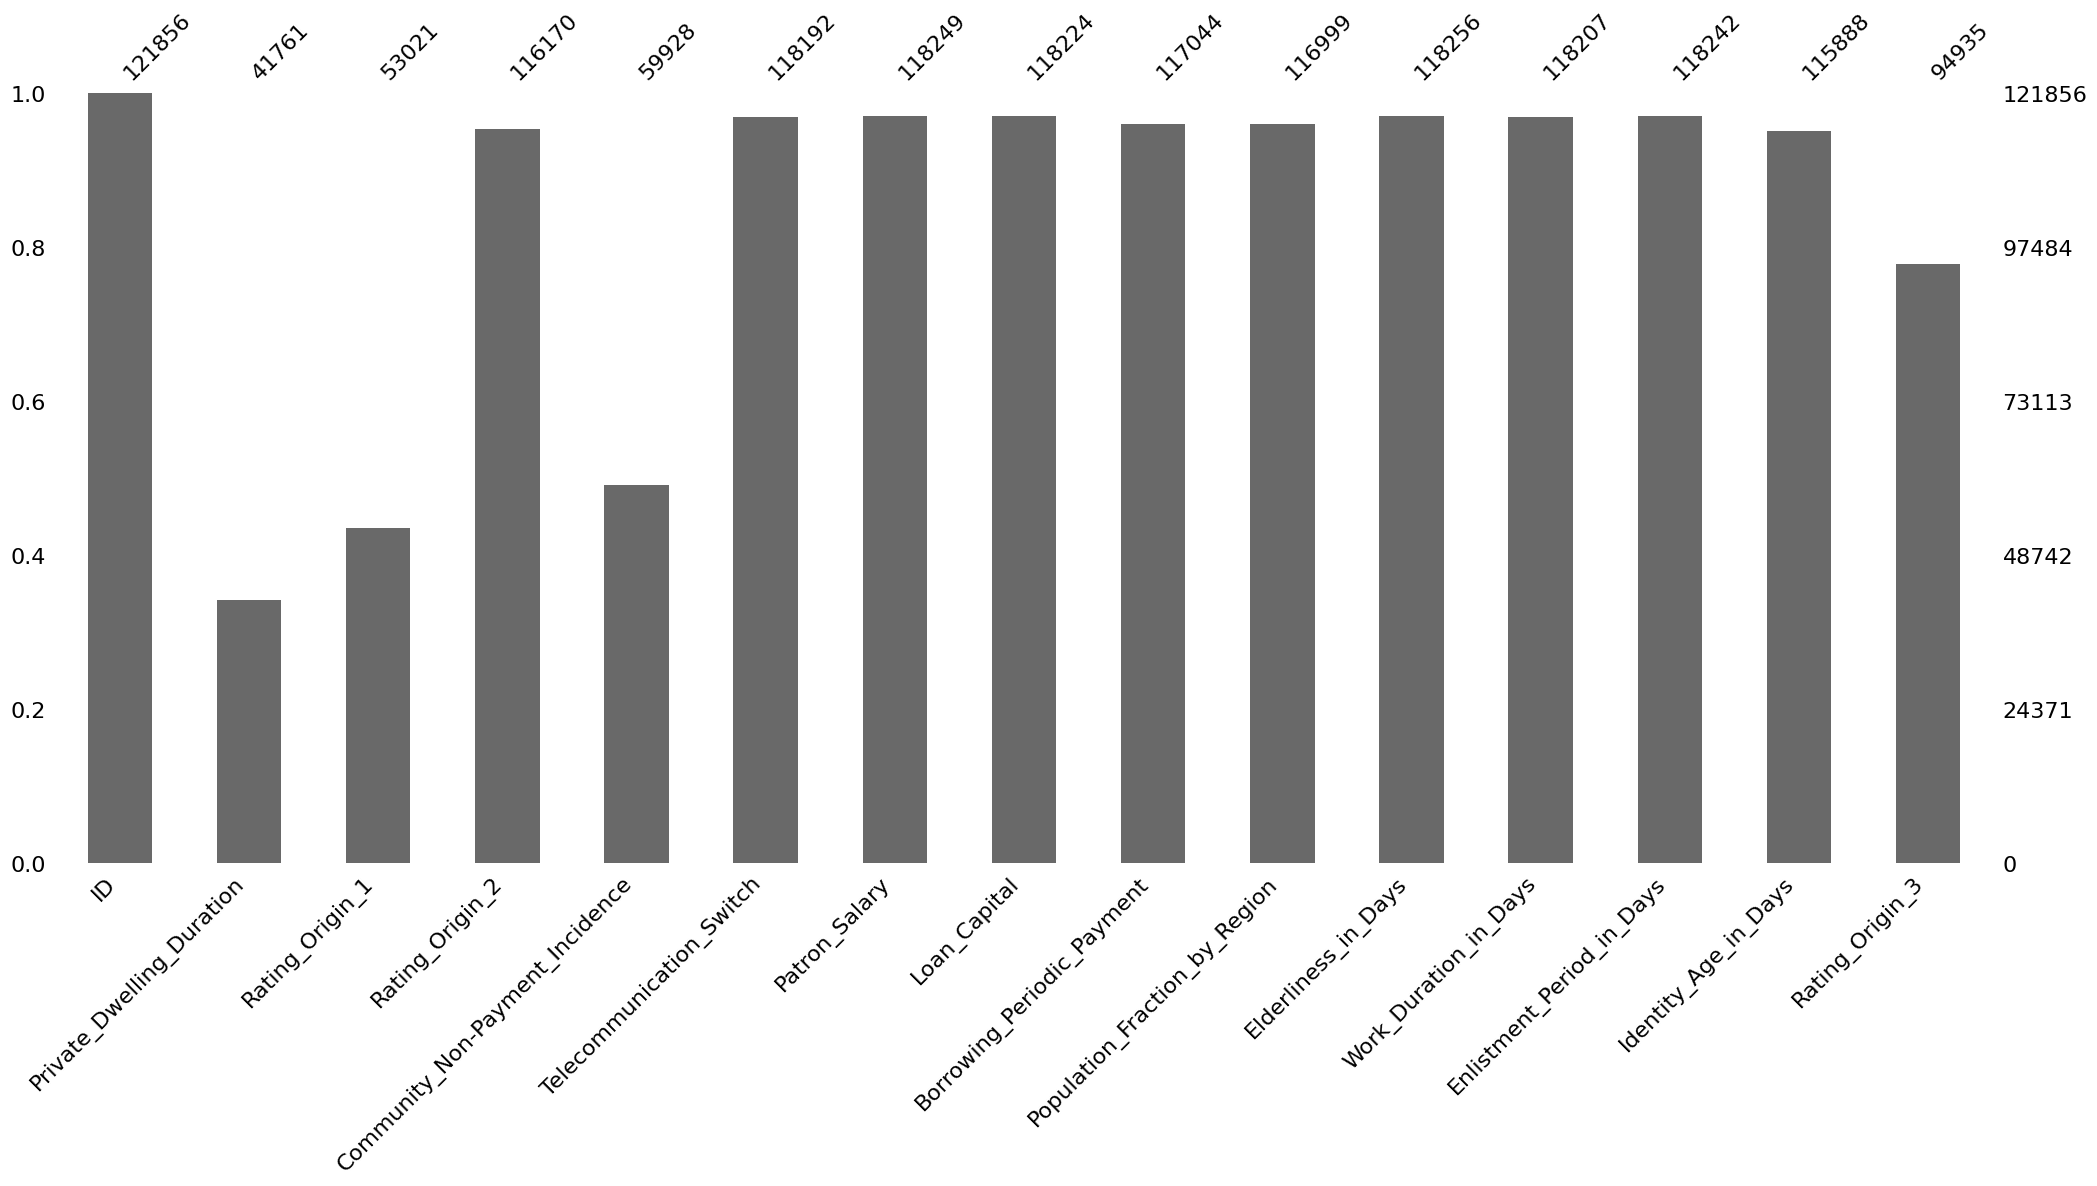

In [4]:
msno.bar(df[num_feat])

<Axes: >

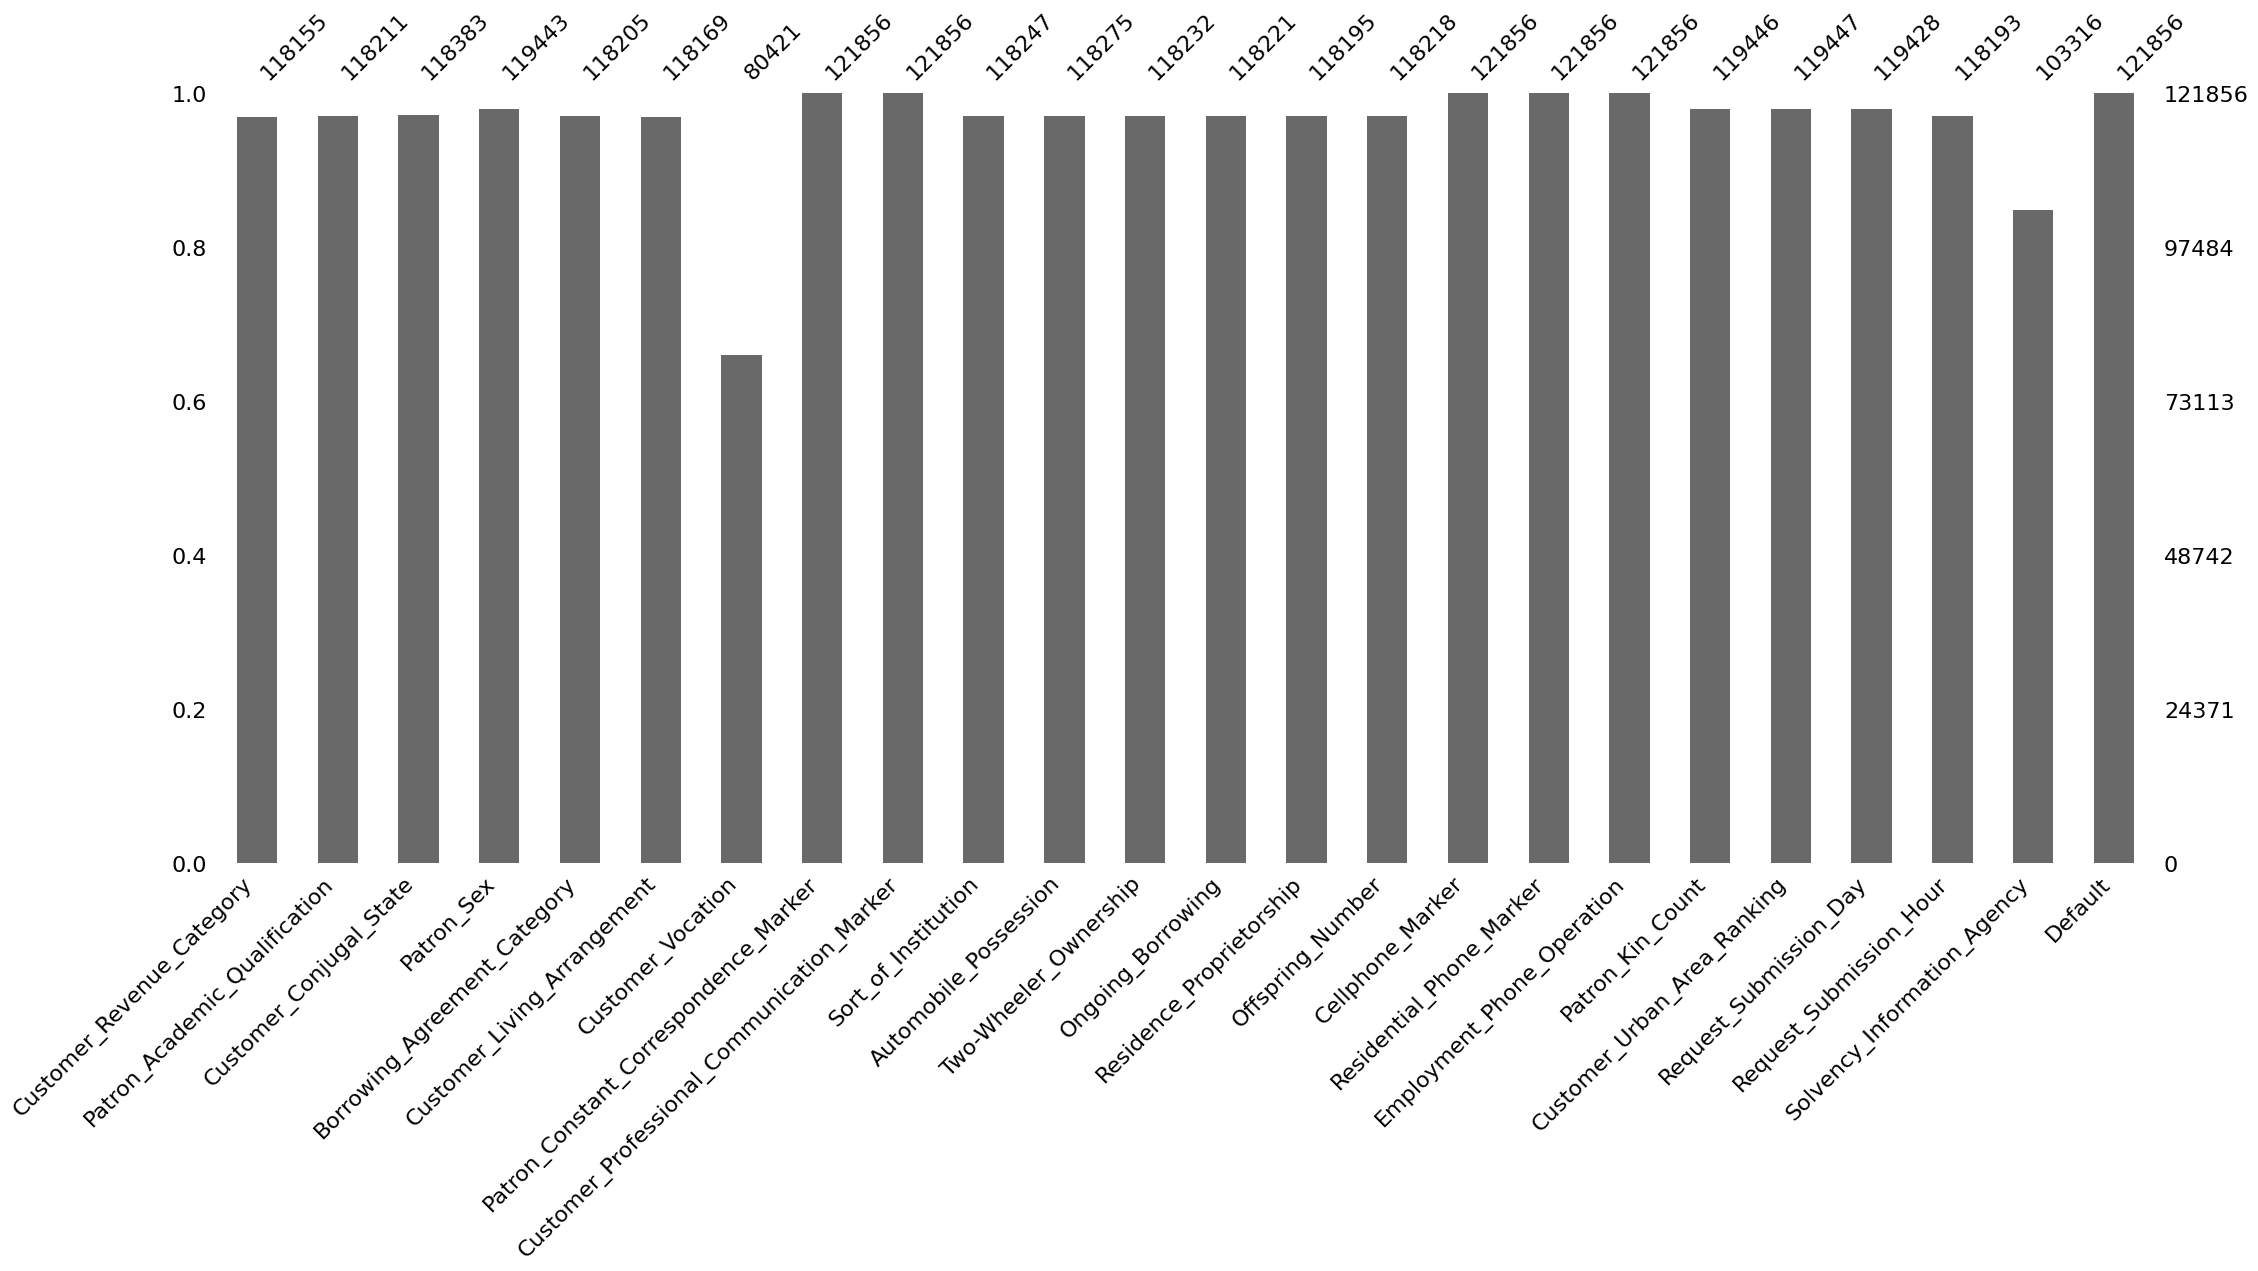

In [5]:
msno.bar(df[cat_feat])

### KNN Imputation for numerical features


In [6]:
from sklearn.impute import KNNImputer
knn_imp=KNNImputer(n_neighbors=2)
# df=knn_imp.fit_transform()
for i,j in enumerate(num_feat):
    print(j)
    df[j]=knn_imp.fit_transform(df[[j]])

ID
Private_Dwelling_Duration
Rating_Origin_1
Rating_Origin_2
Community_Non-Payment_Incidence
Telecommunication_Switch
Patron_Salary
Loan_Capital
Borrowing_Periodic_Payment
Population_Fraction_by_Region
Elderliness_in_Days
Work_Duration_in_Days
Enlistment_Period_in_Days
Identity_Age_in_Days
Rating_Origin_3


### Impute Missing Values for Categorical Features

In [7]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent')
df[cat_feat]=imputer.fit_transform(df[cat_feat])

## Outlier Capping for Numerical Features:


In [8]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [9]:
for i in num_feat:
    detect_outliers(i)


 #### ID ####
percentile25 12130464.75
percentile75 12191392.25
Upper limit 12282783.5
Lower limit 12039073.5

 #### Private_Dwelling_Duration ####
percentile25 12.157323818874069
percentile75 12.157323818874069
Upper limit 12.157323818874069
Lower limit 12.157323818874069

 #### Rating_Origin_1 ####
percentile25 0.5012129250527902
percentile75 0.5012129250527902
Upper limit 0.5012129250527902
Lower limit 0.5012129250527902

 #### Rating_Origin_2 ####
percentile25 0.40199560075
percentile75 0.659828416
Upper limit 1.0465776388749999
Lower limit 0.015246377875000106

 #### Community_Non-Payment_Incidence ####
percentile25 0.0907
percentile75 0.11742785509277799
Upper limit 0.15751963773194497
Lower limit 0.05060821736083302

 #### Telecommunication_Switch ####
percentile25 287.0
percentile75 1550.0
Upper limit 3444.5
Lower limit -1607.5

 #### Patron_Salary ####
percentile25 11250.0
percentile75 20250.0
Upper limit 33750.0
Lower limit -2250.0

 #### Loan_Capital ####
percentile25 27450

## Encoding Categorical features

In [10]:
for i in cat_feat:
    print(len(df[i].value_counts()))
    print(df[i].value_counts(normalize=True)*100)
    print("***____****")
    

8
Customer_Revenue_Category
Service            53.119256
Commercial         22.784270
Retired            17.268743
Govt Job            6.813780
Student             0.006565
Unemployed          0.004924
Maternity leave     0.001641
Businessman         0.000821
Name: proportion, dtype: float64
***____****
5
Patron_Academic_Qualification
Secondary             71.852022
Graduation            23.650046
Graduation dropout     3.249737
Junior secondary       1.194032
Post Grad              0.054162
Name: proportion, dtype: float64
***____****
4
Customer_Conjugal_State
M    74.532235
S    14.282432
D     6.200762
W     4.984572
Name: proportion, dtype: float64
***____****
3
Patron_Sex
Male      66.370142
Female    33.627396
XNA        0.002462
Name: proportion, dtype: float64
***____****
2
Borrowing_Agreement_Category
CL    90.901556
RL     9.098444
Name: proportion, dtype: float64
***____****
6
Customer_Living_Arrangement
Home         89.086299
Family        4.745765
Municipal     3.486082
Re

Since Label encoding might induce hierarchy into the model we will use one hot encoding for features with unique values less than 5 and frequency encoding for features with unique values high than 5.


In [11]:
onehot=[x for x in cat_feat if len(df[x].value_counts())<=3 and x!='Default']
freqenc=[x for x in cat_feat if len(df[x].value_counts())>3 ]


 OneHot

In [12]:
for i in range(len(onehot)):
    # Perform one-hot encoding with custom column names
    temp = pd.get_dummies(df[onehot[i]], drop_first=True, prefix=onehot[i], prefix_sep='_').astype(int)
    df = df.drop(onehot[i], axis="columns")
    df = pd.concat([df, temp], axis='columns')


Frequency Encoding

In [13]:
def frequency_encoding(column):
    freq = column.value_counts(normalize=True)
    encoded_column = column.map(freq)
    return encoded_column

In [14]:
for i in range(len(freqenc)):
    df[freqenc[i]]=frequency_encoding(df[freqenc[i]])

## Scaling the Data

In [15]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
df[num_feat]=ss.fit_transform(df[num_feat])

### Checking for Duplicates

In [16]:
df.duplicated().sum()

0

In [22]:
df.columns

Index(['ID', 'Patron_Salary', 'Offspring_Number', 'Loan_Capital',
       'Borrowing_Periodic_Payment', 'Customer_Revenue_Category',
       'Patron_Academic_Qualification', 'Customer_Conjugal_State',
       'Customer_Living_Arrangement', 'Population_Fraction_by_Region',
       'Elderliness_in_Days', 'Work_Duration_in_Days',
       'Enlistment_Period_in_Days', 'Identity_Age_in_Days',
       'Private_Dwelling_Duration', 'Customer_Vocation', 'Patron_Kin_Count',
       'Request_Submission_Day', 'Request_Submission_Hour',
       'Sort_of_Institution', 'Rating_Origin_1', 'Rating_Origin_2',
       'Rating_Origin_3', 'Community_Non-Payment_Incidence',
       'Telecommunication_Switch', 'Solvency_Information_Agency', 'Default',
       'Patron_Sex_Male', 'Patron_Sex_XNA', 'Borrowing_Agreement_Category_RL',
       'Patron_Constant_Correspondence_Marker_Yes',
       'Customer_Professional_Communication_Marker_Yes',
       'Automobile_Possession_1.0', 'Two-Wheeler_Ownership_1.0',
       'Ongoing_Bor

### Saving the preprocessed data

In [14]:
# saving the file for future purpose
df.to_csv('preprocesseddata.csv', index=False)

In [8]:
df=pd.read_csv('preprocesseddata.csv')

#### Feature importance

In [9]:

y=df['Default']
X=df.drop(['Default','ID'],axis=1)


In [10]:
y=y.astype('int')

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 39 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Patron_Salary                                   121856 non-null  float64
 1   Offspring_Number                                121856 non-null  float64
 2   Loan_Capital                                    121856 non-null  float64
 3   Borrowing_Periodic_Payment                      121856 non-null  float64
 4   Customer_Revenue_Category                       121856 non-null  float64
 5   Patron_Academic_Qualification                   121856 non-null  float64
 6   Customer_Conjugal_State                         121856 non-null  float64
 7   Customer_Living_Arrangement                     121856 non-null  float64
 8   Population_Fraction_by_Region                   121856 non-null  float64
 9   Elderliness_in_Days       

In [12]:
X.columns = X.columns.astype(str)

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [14]:
print(model.feature_importances_)

[4.19590849e-02 1.97602338e-02 4.15810247e-02 4.17438617e-02
 1.91366671e-02 1.49591948e-02 1.98673401e-02 1.46157042e-02
 4.19969446e-02 4.42295253e-02 3.80868467e-02 4.37448724e-02
 4.40501113e-02 0.00000000e+00 2.93004161e-02 2.43486001e-02
 3.87509985e-02 4.11023645e-02 3.41172939e-02 0.00000000e+00
 6.04221573e-02 6.07267244e-02 3.38785920e-02 4.30398562e-02
 3.58512924e-02 1.06169101e-02 1.52922217e-06 7.56231942e-03
 8.80432136e-03 1.52668216e-02 1.51199354e-02 2.20499948e-02
 2.36025055e-02 2.02792050e-02 0.00000000e+00 1.65655498e-02
 1.58104920e-02 9.96823475e-03 7.08247407e-03]


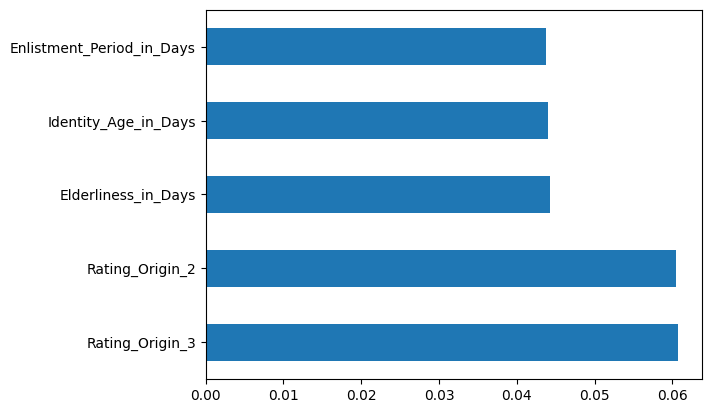

In [15]:
#plot important features
feat_imps=pd.Series(model.feature_importances_,index=X.columns)
feat_imps.nlargest(5).plot(kind='barh')
plt.show()

# Train Test split
Now that we have the features converted into numericals, we know the important features. We will split the data and start fitting it to various algorithms

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=7)


## Model Selection

###### Here We are using four regression algorithms .DecisionTrees and ensemble techniques like RandomForest,Adaboost,Xgboost and Catboost. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [18]:
y_pred = rf.predict(X_test)

In [30]:
def metric_calc(true,predicted):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) 
    f1=f1_score(y_test,y_pred) 
    return precision,recall,accuracy,f1
    

In [20]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,

precision,recall,accuracy,f1 = metric_calc(y_test, y_pred)
print("Accuracy:", accuracy,"precision:",precision,"recall:",recall)

Accuracy: 0.9303826900456821 precision: 1.0 recall: 0.11815661815661815


33671


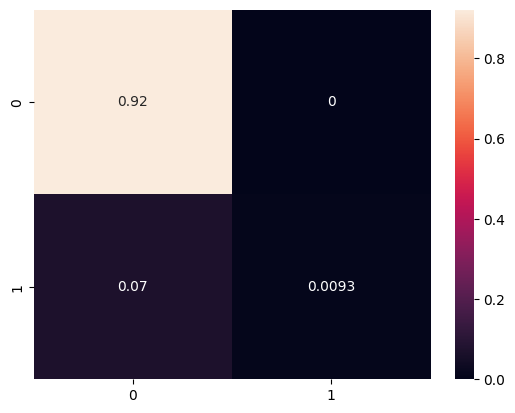

In [21]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print(cm[0][0])
sns.heatmap(cm/np.sum(cm),annot=True)
labels = ['True Neg','False Pos','False Neg','True Pos']

In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
cat_params = {"learning_rate": [0.1, 0.01, 0.06, 0.05],
              "max_depth": [6, 8, 12, 20, 30]}

clf = GridSearchCV( CatBoostClassifier(), cat_params, cv = 3, scoring='f1')
clf.fit(X_train, y_train)

print(clf.best_params_)

print(clf.best_score_)

0:	learn: 0.5927868	total: 162ms	remaining: 2m 41s
1:	learn: 0.5172770	total: 183ms	remaining: 1m 31s
2:	learn: 0.4625218	total: 207ms	remaining: 1m 8s
3:	learn: 0.4188318	total: 229ms	remaining: 57.1s
4:	learn: 0.3846434	total: 255ms	remaining: 50.8s
5:	learn: 0.3566369	total: 276ms	remaining: 45.7s
6:	learn: 0.3362648	total: 295ms	remaining: 41.8s
7:	learn: 0.3205892	total: 316ms	remaining: 39.2s
8:	learn: 0.3087062	total: 340ms	remaining: 37.4s
9:	learn: 0.2989466	total: 364ms	remaining: 36s
10:	learn: 0.2904138	total: 388ms	remaining: 34.9s
11:	learn: 0.2834330	total: 413ms	remaining: 34s
12:	learn: 0.2787086	total: 442ms	remaining: 33.5s
13:	learn: 0.2749991	total: 473ms	remaining: 33.3s
14:	learn: 0.2716241	total: 495ms	remaining: 32.5s
15:	learn: 0.2689724	total: 518ms	remaining: 31.8s
16:	learn: 0.2669902	total: 540ms	remaining: 31.2s
17:	learn: 0.2650361	total: 566ms	remaining: 30.9s
18:	learn: 0.2635432	total: 588ms	remaining: 30.4s
19:	learn: 0.2623183	total: 612ms	remaining

c:\Msc DS\CarDheko-Price-Prediction\carprice\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Msc DS\CarDheko-Price-Prediction\carprice\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Msc DS\CarDheko-Price-Prediction\carprice\lib\site-packages\catboost\core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Msc DS\CarD

0:	learn: 0.5939861	total: 50.7ms	remaining: 50.6s
1:	learn: 0.5154061	total: 314ms	remaining: 2m 36s
2:	learn: 0.4519771	total: 528ms	remaining: 2m 55s
3:	learn: 0.4067498	total: 729ms	remaining: 3m 1s
4:	learn: 0.3709347	total: 932ms	remaining: 3m 5s
5:	learn: 0.3454764	total: 1.11s	remaining: 3m 4s
6:	learn: 0.3239816	total: 1.31s	remaining: 3m 5s
7:	learn: 0.3080365	total: 1.49s	remaining: 3m 4s
8:	learn: 0.2970232	total: 1.67s	remaining: 3m 3s
9:	learn: 0.2854120	total: 1.86s	remaining: 3m 4s
10:	learn: 0.2781247	total: 2.04s	remaining: 3m 3s
11:	learn: 0.2713238	total: 2.23s	remaining: 3m 3s
12:	learn: 0.2650808	total: 2.43s	remaining: 3m 4s
13:	learn: 0.2600852	total: 2.62s	remaining: 3m 4s
14:	learn: 0.2560875	total: 2.81s	remaining: 3m 4s
15:	learn: 0.2528371	total: 3s	remaining: 3m 4s
16:	learn: 0.2498808	total: 3.19s	remaining: 3m 4s
17:	learn: 0.2462997	total: 3.39s	remaining: 3m 5s
18:	learn: 0.2440114	total: 3.58s	remaining: 3m 4s
19:	learn: 0.2414812	total: 3.77s	remaini

In [23]:
best_params=clf.best_params_
best_score=clf.best_score_

In [34]:
best_params

{'learning_rate': 0.1, 'max_depth': 12}